In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [11]:
# Load dataset
df = pd.read_csv('cpu_scheduling_dataset.csv')

print("Dataset Info:")
df.info()

# Separate features (X) and target (y)
X = df.drop('best_algorithm', axis=1)
y = df['best_algorithm']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875 entries, 0 to 1874
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   num_processes            1875 non-null   int64  
 1   avg_burst_time           1875 non-null   float64
 2   std_burst_time           1875 non-null   float64
 3   min_burst_time           1875 non-null   float64
 4   max_burst_time           1875 non-null   float64
 5   avg_arrival_time         1875 non-null   float64
 6   arrival_spread           1875 non-null   float64
 7   avg_inter_arrival        1875 non-null   float64
 8   avg_priority             1875 non-null   float64
 9   std_priority             1875 non-null   float64
 10  time_quantum             1875 non-null   float64
 11  quantum_to_avg_burst     1875 non-null   float64
 12  burst_variance_ratio     1875 non-null   float64
 13  total_burst_time         1875 non-null   float64
 14  system_loa

In [12]:
# Crucial: Initialize encoders and scalers
le = LabelEncoder()
sl = StandardScaler()

# Transform Target Labels (e.g., 'FCFS' -> 0, 'SJF' -> 1)
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Scale Features (Mean=0, Variance=1)
X_train_scaled = sl.fit_transform(X_train)
X_test_scaled = sl.transform(X_test)

print(f"Classes found: {le.classes_}")
print(f"Training shape: X={X_train_scaled.shape}, y={y_train_encoded.shape}")

Classes found: ['FCFS' 'RR' 'SJF']
Training shape: X=(1500, 17), y=(1500,)


In [13]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{'='*50}")
    print(f"MODEL: {model_name}")
    print(f"{'='*50}")
    print(f"Accuracy Score: {accuracy_score(y_true, y_pred):.4f}")
    
    print("\nConfusion Matrix:")
    # Using seaborn for a prettier confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))


MODEL: RandomForest
Accuracy Score: 0.6160

Confusion Matrix:


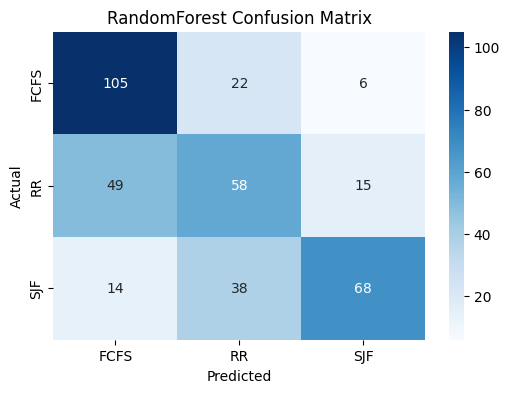


Classification Report:
              precision    recall  f1-score   support

        FCFS       0.62      0.79      0.70       133
          RR       0.49      0.48      0.48       122
         SJF       0.76      0.57      0.65       120

    accuracy                           0.62       375
   macro avg       0.63      0.61      0.61       375
weighted avg       0.63      0.62      0.61       375


MODEL: XGBoost
Accuracy Score: 0.6427

Confusion Matrix:


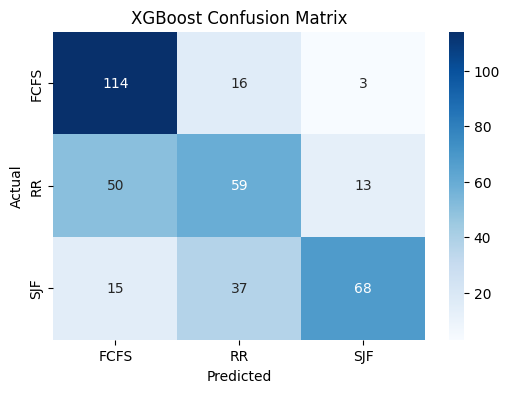


Classification Report:
              precision    recall  f1-score   support

        FCFS       0.64      0.86      0.73       133
          RR       0.53      0.48      0.50       122
         SJF       0.81      0.57      0.67       120

    accuracy                           0.64       375
   macro avg       0.66      0.64      0.63       375
weighted avg       0.66      0.64      0.64       375



In [14]:
# Using the best parameters you found earlier!
models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=200,
        min_samples_split=2,
        min_samples_leaf=2,
        max_features='log2',
        max_depth=30,
        criterion='gini',
        class_weight='balanced', # Add this line!
        bootstrap=False,
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        subsample=0.6,
        reg_lambda=2,
        reg_alpha=0,
        n_estimators=100,
        max_depth=10,
        learning_rate=0.05,
        gamma=0.3,
        colsample_bytree=0.8,
        random_state=42
    )
}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train_scaled, y_train_encoded)
    y_pred = model.predict(X_test_scaled)
    evaluate_model(y_test_encoded, y_pred, name)

# Save the best traditional model (Random Forest usually wins here)
best_rf = models['RandomForest']

In [15]:
# We must export the model, the scaler, AND the label encoder!
import os

# Create a models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save Random Forest
with open('models/RandomForest.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

# Save Scaler
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(sl, f)

# Save Label Encoder (Crucial for the test script!)
with open('models/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
    

print("All models, scalers, and encoders saved successfully in the 'models' folder!")

All models, scalers, and encoders saved successfully in the 'models' folder!
